In [2]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
#using JWAS:misc               # utility functions
using JWAS.Datasets                       # package for plotting 
using CSV
using DelimitedFiles
using Statistics

In [4]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end
@time M = readMatBin("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.gen.bin")

 27.115021 seconds (30.73 k allocations: 10.393 GiB, 0.07% gc time)


3205×435172 Array{Float64,2}:
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  2.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 1.0  1.0  0.0  1.0  2.0  0.0  0.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

## BV correlation for MHC region from MCMC BayesB samples

In [116]:
SNP_Effect_ADG= readdlm("CMIR_Score4/BayesB/MCMC_samples_marker_effects_geno_CMIR.txt", ',',header=false)
SNP_Effect_ADG= SNP_Effect_ADG[2:451,:]
# Get marker effects for MHC region 20 to 30mb
Effect_ADG_MHC= SNP_Effect_ADG[:, 185212:187459]  # obtained from Map info
# Get genotypes for MHC region
M_MHC= M[:, 185212:187459]
M_MHC'
BV_ADG_MHC= Effect_ADG_MHC * M_MHC'
var_ADG= vec(var(BV_ADG_MHC, dims=2))  # Get var for each iteration

# Get var for AllTRT
SNP_Effect_AllTRT= readdlm("CMIR_Score4/BayesB/MCMC_samples_marker_effects_geno_Health_Score4.txt", ',',header=false)
SNP_Effect_AllTRT= SNP_Effect_AllTRT[2:451,:]
# Get marker effects for MHC region 20 to 30mb
Effect_AllTRT_MHC= SNP_Effect_AllTRT[:, 185212:187459]
BV_AllTRT_MHC= Effect_AllTRT_MHC * M_MHC'
var_AllTRT= vec(var(BV_AllTRT_MHC, dims=2)) # Get var for each iteration

coVar = Array{Float64,1}()
for i=1:450
    adg= BV_ADG_MHC[i,:]
    AllTRT= BV_AllTRT_MHC[i,:]
    covi=cov(adg, AllTRT)
    push!(coVar,covi)
end

out=DataFrame(covar=coVar)
insertcols!(out, 1, :var_ADG => var_ADG)
insertcols!(out, 1, :var_AllTRT => var_AllTRT)
insertcols!(out, 1, :iteration => 1:450) # Add a column called iteration


# genetic correlation
Product= out[!,:var_AllTRT] .* out[!,:var_ADG]  # product of vars
sqVar=[sqrt(i) for i in Product]  # get sqrt for whole vector
rg= out[!,:covar] ./ sqVar[:,]  # Genetic correlations
insertcols!(out, 2, :corr => rg)

,iteration,corr,var_AllTRT,var_ADG,covar
,Int64,Float64,Float64,Float64,Float64
1,1,0.494528,0.000256601,9.24712e-5,7.61769e-5
2,2,0.309898,0.000351121,6.1389e-5,4.54981e-5
3,3,0.318354,0.000775818,0.000148727,0.00010814
4,4,-0.0868045,0.00041736,0.0005468,-4.14679e-5
5,5,0.0859703,0.000884745,1.4398e-5,9.70306e-6
6,6,0.297302,0.00205293,4.52206e-5,9.05842e-5
7,7,0.435648,0.00048932,0.000639306,0.000243661
8,8,-0.361789,0.000640996,9.82729e-5,-9.08029e-5
9,9,0.332904,0.00256015,3.19218e-5,9.5169e-5


In [117]:
out= filter(row -> ! isnan(row.corr), out)
mean(out[:corr])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[117]:2
└ @ Core In[117]:2


-0.04385263282834168

In [118]:
std(out[:corr])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[118]:1
└ @ Core In[118]:1


0.4359736233063462

## BV correlation for Chr17 region from MCMC BayesB samples

In [119]:
SNP_Effect_ADG= readdlm("CMIR_Score4/BayesB/MCMC_samples_marker_effects_geno_CMIR.txt", ',',header=false)
SNP_Effect_ADG= SNP_Effect_ADG[2:451,:]
# Get marker effects for MHC region 45 to 55mb
Effect_ADG_MHC= SNP_Effect_ADG[:, 419276:421982]  # obtained from Map info
# Get genotypes for MHC region
M_MHC= M[:, 419276:421982]
M_MHC'
BV_ADG_MHC= Effect_ADG_MHC * M_MHC'
var_ADG= vec(var(BV_ADG_MHC, dims=2))  # Get var for each iteration

# Get var for AllTRT
SNP_Effect_AllTRT= readdlm("CMIR_Score4/BayesB/MCMC_samples_marker_effects_geno_Health_Score4.txt", ',',header=false)
SNP_Effect_AllTRT= SNP_Effect_AllTRT[2:451,:]
# Get marker effects for MHC region 45 to 55 mb
Effect_AllTRT_MHC= SNP_Effect_AllTRT[:, 419276:421982]
BV_AllTRT_MHC= Effect_AllTRT_MHC * M_MHC'
var_AllTRT= vec(var(BV_AllTRT_MHC, dims=2)) # Get var for each iteration

coVar = Array{Float64,1}()
for i=1:450
    adg= BV_ADG_MHC[i,:]
    AllTRT= BV_AllTRT_MHC[i,:]
    covi=cov(adg, AllTRT)
    push!(coVar,covi)
end

out=DataFrame(covar=coVar)
insertcols!(out, 1, :var_ADG => var_ADG)
insertcols!(out, 1, :var_AllTRT => var_AllTRT)
insertcols!(out, 1, :iteration => 1:450) # Add a column called iteration

# genetic correlation
Product= out[!,:var_AllTRT] .* out[!,:var_ADG]  # product of vars
sqVar=[sqrt(i) for i in Product]  # get sqrt for whole vector
rg= out[!,:covar] ./ sqVar[:,]  # Genetic correlations
insertcols!(out, 2, :corr => rg)

,iteration,corr,var_AllTRT,var_ADG,covar
,Int64,Float64,Float64,Float64,Float64
1,1,0.622604,0.00048608,0.000126887,0.000154623
2,2,0.452872,0.00123679,0.000594941,0.000388472
3,3,-0.745094,0.000205631,7.48104e-5,-9.24136e-5
4,4,0.298934,0.00281896,0.000209966,0.000229983
5,5,0.463564,0.000973386,4.74799e-5,9.96568e-5
6,6,-0.677217,0.00158079,0.000143249,-0.000322263
7,7,-0.638254,0.00329075,9.19746e-5,-0.000351136
8,8,0.0195385,0.00169517,3.78754e-6,1.56558e-6
9,9,-0.109984,0.000141715,0.000241299,-2.03383e-5


In [120]:
# filter out missing rows
out= filter(row -> ! isnan(row.corr), out)
mean(out[:corr])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[120]:3
└ @ Core In[120]:3


-0.0959254805553512

In [121]:
std(out[:corr])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[121]:1
└ @ Core In[121]:1


0.35430038762048827

## Whole genome genetic correlation

In [41]:
gVar= CSV.read("CMIR_Score4/BayesB/MCMC_samples_genetic_variance.txt")

,CMIR_CMIR,CMIR_Health_Score4,Health_Score4_CMIR,Health_Score4_Health_Score4
,Float64,Float64,Float64,Float64
1,0.0346081,-0.0085265,-0.0085265,0.162982
2,0.0222501,-0.00146169,-0.00146169,0.142672
3,0.0264888,-0.00898466,-0.00898466,0.153198
4,0.0235468,-0.0032415,-0.0032415,0.149368
5,0.0187684,-0.0051792,-0.0051792,0.154327
6,0.0250464,-0.00894477,-0.00894477,0.146076
7,0.026118,-0.00837829,-0.00837829,0.155179
8,0.0227775,-0.004783,-0.004783,0.213058
9,0.0215038,-0.00775024,-0.00775024,0.167683


In [42]:
sqVar1=[sqrt(i) for i in gVar[!,:Health_Score4_Health_Score4]] 
sqVar2=[sqrt(i) for i in gVar[!,:CMIR_CMIR]] 
Product= sqVar1 .* sqVar2
rg= gVar[!,:Health_Score4_CMIR] ./ Product  # Genetic correlations
insertcols!(gVar, 2, :corr => rg)

,CMIR_CMIR,corr,CMIR_Health_Score4,Health_Score4_CMIR,Health_Score4_Health_Score4
,Float64,Float64,Float64,Float64,Float64
1,0.0346081,-0.11353,-0.0085265,-0.0085265,0.162982
2,0.0222501,-0.025943,-0.00146169,-0.00146169,0.142672
3,0.0264888,-0.14104,-0.00898466,-0.00898466,0.153198
4,0.0235468,-0.0546579,-0.0032415,-0.0032415,0.149368
5,0.0187684,-0.0962338,-0.0051792,-0.0051792,0.154327
6,0.0250464,-0.147879,-0.00894477,-0.00894477,0.146076
7,0.026118,-0.131604,-0.00837829,-0.00837829,0.155179
8,0.0227775,-0.068659,-0.004783,-0.004783,0.213058
9,0.0215038,-0.129067,-0.00775024,-0.00775024,0.167683


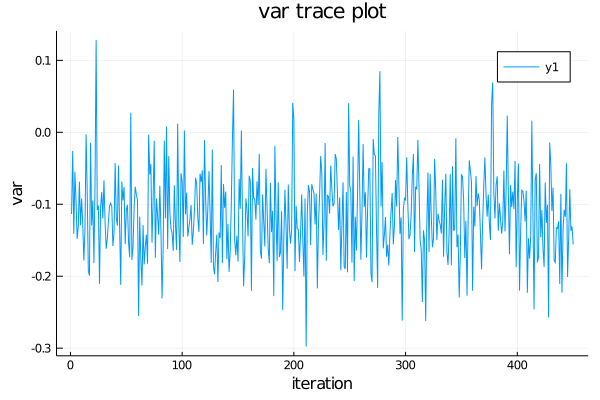

In [43]:
insertcols!(gVar, 1, :iteration => 1:450)
using Plots
x = gVar[!,1]; y = gVar[!,3]; # These are the plotting data
plot(x,y, title = "var trace plot",
        xlabel = "iteration", ylabel = "var")

In [44]:
#using Pkg
#Pkg.add("StatsBase")
using(StatsBase)
mean(gVar[!,3])

-0.11305145586037554

In [45]:
std(gVar[!,3])

0.061004528889224655

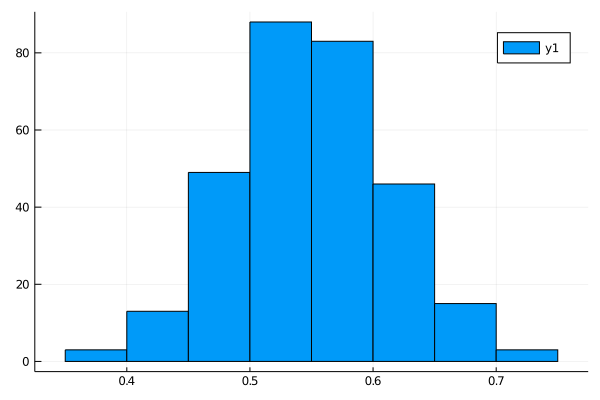

In [21]:
using Plots
h = histogram(gVar[!,3])
display(h)